In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

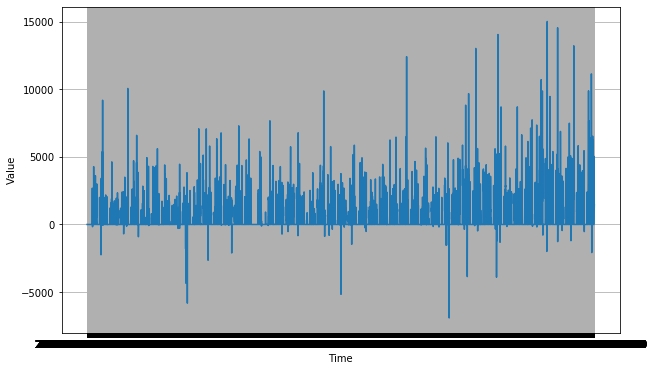

In [5]:
import csv
time_step = []
quantity = []

with open('newdf3.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    quantity.append(float(row[2]))
    time_step.append((row[1]))

series = np.array(quantity)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

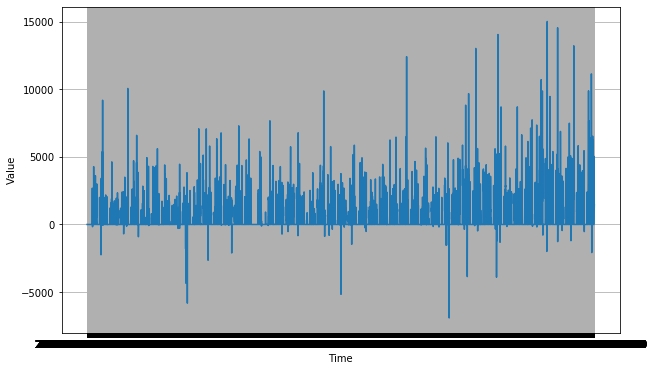

In [6]:
series = np.array(quantity)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [21]:
split_time = 7300
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

#window_size = 30
#batch_size = 32
shuffle_buffer_size = 1000

In [22]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [23]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [24]:
tf.random.set_seed(51)
np.random.seed(51)
window_size = 32
batch_size = 32
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=6e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(7300,)
Epoch 1/100
228/228 [==============================] - 7s 30ms/step - loss: 417.3588 - mae: 417.8070
Epoch 2/100
228/228 [==============================] - 7s 31ms/step - loss: 415.9694 - mae: 416.4575
Epoch 3/100
228/228 [==============================] - 7s 33ms/step - loss: 414.8550 - mae: 415.3501
Epoch 4/100
228/228 [==============================] - 7s 29ms/step - loss: 413.8666 - mae: 414.3620
Epoch 5/100
228/228 [==============================] - 7s 29ms/step - loss: 412.8174 - mae: 413.3109: 4s 
Epoch 6/100
228/228 [==============================] - 7s 29ms/step - loss: 411.7325 - mae: 412.2216
Epoch 7/100
228/228 [==============================] - 7s 30ms/step - loss: 410.7435 - mae: 411.2267
Epoch 8/100
228/228 [==============================] - 7s 29ms/step - loss: 409.7461 - mae: 410.2252
Epoch 9/100
228/228 [==============================] - 7s 29ms/step - loss: 408.6334 

[1e-08, 0.0001, 0, 500]

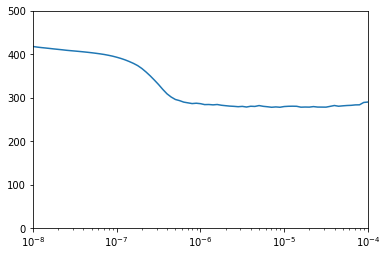

In [25]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 500])

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=64, batch_size=32, shuffle_buffer=shuffle_buffer_size)
#32,16
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=6e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=700)

Epoch 1/700
227/227 [==============================] - 14s 62ms/step - loss: 332.5599 - mae: 333.0343
Epoch 2/700
227/227 [==============================] - 17s 76ms/step - loss: 282.5498 - mae: 283.0108
Epoch 3/700
227/227 [==============================] - 14s 61ms/step - loss: 279.3824 - mae: 279.8394
Epoch 4/700
227/227 [==============================] - 14s 63ms/step - loss: 275.4380 - mae: 275.8707
Epoch 5/700
227/227 [==============================] - 14s 63ms/step - loss: 276.0390 - mae: 276.4453
Epoch 6/700
227/227 [==============================] - 14s 63ms/step - loss: 273.6549 - mae: 274.0381
Epoch 7/700
227/227 [==============================] - 14s 63ms/step - loss: 273.3121 - mae: 273.6316
Epoch 8/700
227/227 [==============================] - 14s 60ms/step - loss: 272.7904 - mae: 273.0586
Epoch 9/700
227/227 [==============================] - 14s 61ms/step - loss: 272.5242 - mae: 272.7585
Epoch 10/700
227/227 [==============================] - 15s 67ms/step - loss: 271.

In [27]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

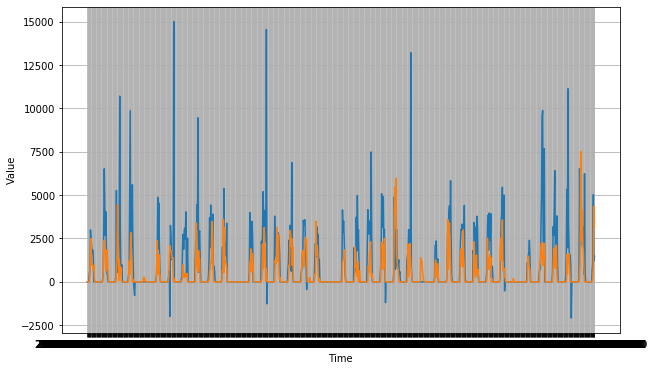

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [29]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

627.36505

<Figure size 432x288 with 0 Axes>

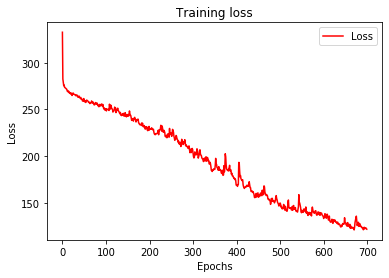

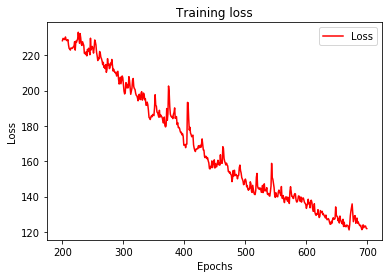

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,700)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [32]:
print(rnn_forecast)

[-2.38141343e-01 -2.36440569e-01 -2.36440569e-01 -2.36440569e-01
 -2.44139388e-01  4.69425903e+02  2.09406909e+03  2.49172290e+03
  9.60025330e+02  1.04783655e+03  9.11578064e+02  6.76332703e+02
  9.46178894e+02  1.76151947e+02 -2.52808034e-01 -2.36440569e-01
 -2.40205884e-01 -2.36752391e-01 -2.54662842e-01 -2.49833405e-01
 -2.82558948e-01 -3.24269801e-01 -3.08638543e-01 -3.19622815e-01
 -3.08787465e-01 -2.77769297e-01 -2.45594367e-01 -2.36440569e-01
 -2.36440569e-01  6.30127502e+02  1.98716223e+03  2.40310693e+03
  1.92894324e+03  1.65071240e+03  6.42228638e+02  9.73973083e+02
  1.84788965e+03  1.06534570e+03  4.23824921e+02 -2.88949162e-01
 -3.11058849e-01 -3.25640440e-01 -2.95177996e-01 -2.95217574e-01
 -2.88685948e-01 -2.61892796e-01 -2.36440569e-01 -2.36440569e-01
 -2.36440569e-01 -2.36440569e-01 -2.36440569e-01 -2.36440569e-01
 -2.36440569e-01  8.51134277e+02  1.50703760e+03  4.44342090e+03
  2.62761279e+03  7.79540405e+01  1.29035474e+03  9.08254517e+02
  3.77188934e+02  8.47550